In [1]:
import sys
sys.path.append("/home/bgreene/LES-utils/")
sys.path.append("/home/bgreene/LES-utils/scripts/")
import xarray as xr
import numpy as np
import seaborn as sb
from LESutils import load_stats
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rc
from RFM import recalc_err_array

In [2]:
# plotting setup
rc("font",weight="normal",size=20,family="serif",serif="Times New Roman")
rc("text",usetex="True")
props=dict(boxstyle="square",facecolor="white",edgecolor="white",alpha=0.0)

# Load Data

In [3]:
# directories
# figure save
figdir = "/home/bgreene/CBL-DOE/figures/RFM/"
savefig = False
# list of simulations to loop over
sims = ["u15_tw03_qw01_dq-06", "u15_tw10_qw04_dq-06", "u15_tw24_qw10_dq-06", 
        "u09_tw24_qw10_dq-06"]#, "u01_tw24_qw10_dq-06"]
# empty list to construct paths and store
dnc_all = []
sall = []
Lall = []
err = []
Call, pall = [], []
# loop over sims and load stats, spectrogram data
for sim in sims:
    dnc = f"/home/bgreene/simulations/CBL/{sim}/"
    dnc_all.append(dnc)
    # load stats file
    s = load_stats(dnc+"mean_stats_xyt_5-6h.nc")
    # add labels using -zi/L
    ziL = -1 * (s.h/s.L).values
    s.attrs["ziL"] = f"$-z_i/L = {ziL:.1f}$"
    sall.append(s)
    # load integral lengthscales
    l = xr.load_dataset(dnc+"lengthscale.nc")
    Lall.append(l)
    # load error files
    e = xr.load_dataset(dnc+"err.nc")
    err.append(e)
    # load RFM coefficients
    Call.append(xr.load_dataset(dnc+"fit_C.nc"))
    pall.append(xr.load_dataset(dnc+"fit_p.nc"))
    
# define colormap based on number of simulations
nsim = len(sims)
cmap = sb.color_palette("cubehelix_r", nsim)
colors = sb.color_palette("rocket_r", nsim)

Reading file: /home/bgreene/simulations/CBL/u15_tw03_qw01_dq-06/mean_stats_xyt_5-6h.nc
Reading file: /home/bgreene/simulations/CBL/u15_tw10_qw04_dq-06/mean_stats_xyt_5-6h.nc
Reading file: /home/bgreene/simulations/CBL/u15_tw24_qw10_dq-06/mean_stats_xyt_5-6h.nc
Reading file: /home/bgreene/simulations/CBL/u09_tw24_qw10_dq-06/mean_stats_xyt_5-6h.nc


In [4]:
# print statistics from simulations
print("Ug, wt_s, wq_s, zi, L, -zi/L, ustar, wstar, Tstar, Qstar")
for s in sall:
    print(f"{s.Ug}, {s.wt_s:.2f}, {s.wq_s:.2f}, {s.ht.values:.0f}, {s.L.values:.2f}, {(-1*s.ht/s.L).values:.2f} {s.ustar0.values:.2f}, {s.wstar.values:.2f}, {s.Tstar0.values:.3f}, {s.Qstar0.values:.3f}")

Ug, wt_s, wq_s, zi, L, -zi/L, ustar, wstar, Tstar, Qstar
15.0, 0.03, 0.01, 1024, -795.76, 1.29 0.68, 1.04, 0.030, 0.012
15.0, 0.10, 0.04, 1118, -293.91, 3.80 0.73, 1.59, 0.065, 0.026
15.0, 0.24, 0.10, 1376, -149.73, 9.19 0.78, 2.30, 0.108, 0.045
9.0, 0.24, 0.10, 1361, -55.39, 24.57 0.56, 2.28, 0.109, 0.046


# Figures

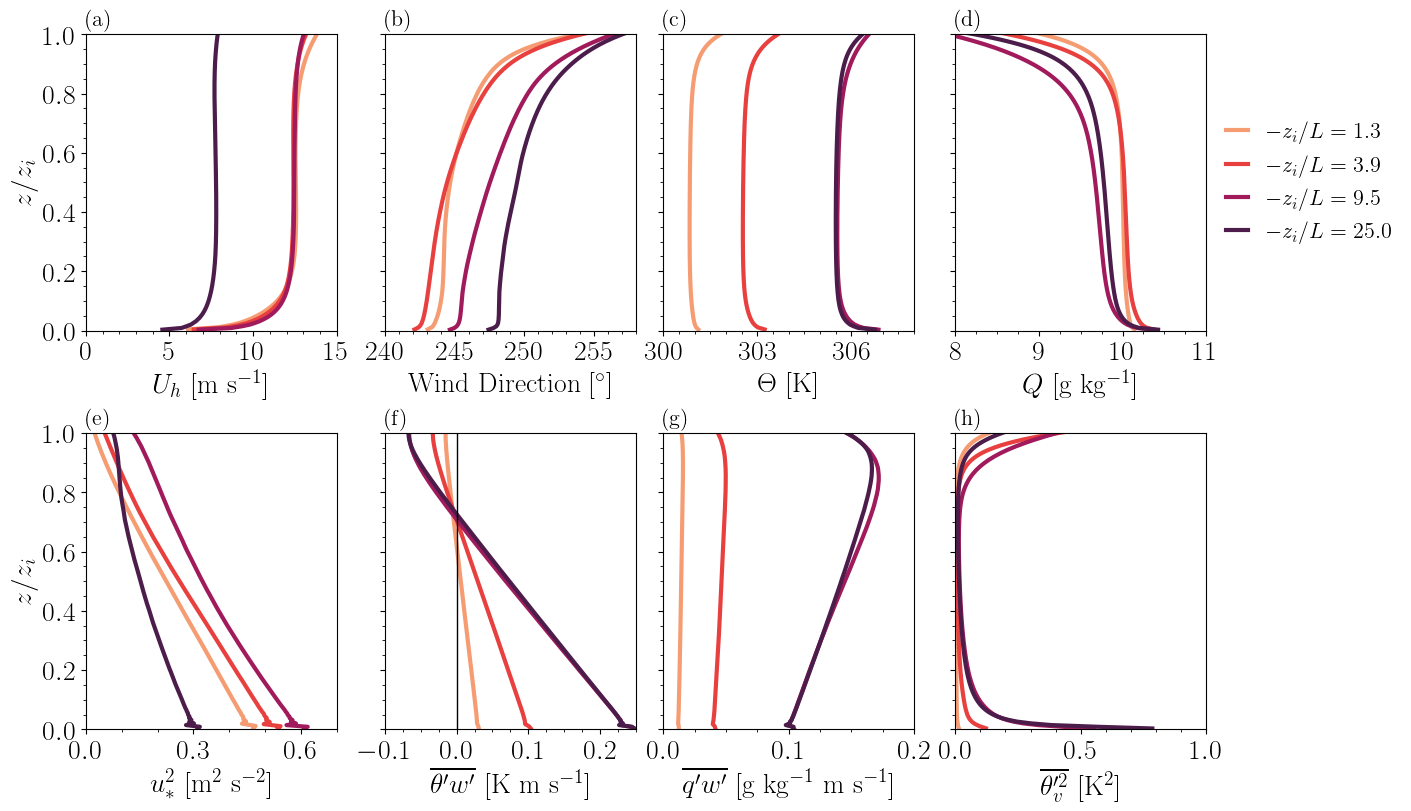

In [5]:
# mean profiles
fig, ax = plt.subplots(2, 4, sharey=True, figsize=(14, 8), constrained_layout=True)
for js, (e, s) in enumerate(zip(err, sall)):
    # row 1
    # wspd
    ax[0,0].plot(s.uh, s.z/s.ht, c=colors[js], lw=3, label=s.ziL)
    # wdir
    ax[0,1].plot(s.wdir, s.z/s.ht, c=colors[js], lw=3)
    # theta
    ax[0,2].plot(s.theta_mean, s.z/s.ht, c=colors[js], lw=3)
    # q
    ax[0,3].plot(s.q_mean, s.z/s.ht, c=colors[js], lw=3, label=s.ziL)
    # row 2
    # ustar2
    ax[1,0].plot(s.ustar2, s.z/s.ht, c=colors[js], lw=3, label=s.ziL)
    # t'w'
    ax[1,1].plot(s.tw_cov_tot, s.z/s.ht, c=colors[js], lw=3)
    # q'w'
    ax[1,2].plot(s.qw_cov_tot, s.z/s.ht, c=colors[js], lw=3)
    # tv'tv'
    ax[1,3].plot(s.thetav_var, s.z/s.ht, c=colors[js], lw=3, label=s.ziL)

# axis labels
ax[0,0].set_ylabel("$z/z_i$")
ax[0,0].set_xlabel(r"$U_h$ [m s$^{-1}$]")
ax[0,1].set_xlabel(r"Wind Direction [$^\circ$]")
ax[0,2].set_xlabel(r"$\Theta$ [K]")
ax[0,3].set_xlabel(r"$Q$ [g kg$^{-1}$]")
ax[1,0].set_ylabel("$z/z_i$")
ax[1,0].set_xlabel(r"$u_*^2$ [m$^{2}$ s$^{-2}$]")
ax[1,1].set_xlabel(r"$\overline{\theta'w'}$ [K m s$^{-1}$]")
ax[1,2].set_xlabel(r"$\overline{q'w'}$ [g kg$^{-1}$ m s$^{-1}$]")
ax[1,3].set_xlabel(r"$\overline{\theta_v'^2}$ [K$^2$]")

# axis limits
ax[0,0].set_ylim([0, 1])
ax[0,0].set_xlim([0, 15])
ax[0,1].set_xlim([240, 258])
ax[0,2].set_xlim([300, 308])
ax[0,3].set_xlim([8, 11])
ax[1,0].set_xlim([0, 0.7])
ax[1,1].set_xlim([-0.1, 0.25])
ax[1,2].set_xlim([0, 0.2])
ax[1,3].set_xlim([0, 1])

# axis ticks and vertical lines
ax[0,0].yaxis.set_major_locator(MultipleLocator(0.2))
ax[0,0].yaxis.set_minor_locator(MultipleLocator(0.05))

ax[0,0].xaxis.set_major_locator(MultipleLocator(5))
ax[0,0].xaxis.set_minor_locator(MultipleLocator(1))
ax[0,1].xaxis.set_major_locator(MultipleLocator(5))
ax[0,1].xaxis.set_minor_locator(MultipleLocator(1))
ax[0,2].xaxis.set_major_locator(MultipleLocator(3))
ax[0,2].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[0,3].xaxis.set_major_locator(MultipleLocator(1))
ax[0,3].xaxis.set_minor_locator(MultipleLocator(0.25))

ax[1,0].xaxis.set_major_locator(MultipleLocator(0.3))
ax[1,0].xaxis.set_minor_locator(MultipleLocator(0.1))
ax[1,1].xaxis.set_major_locator(MultipleLocator(0.1))
ax[1,1].xaxis.set_minor_locator(MultipleLocator(0.025))
ax[1,2].xaxis.set_major_locator(MultipleLocator(0.1))
ax[1,2].xaxis.set_minor_locator(MultipleLocator(0.025))
ax[1,3].xaxis.set_major_locator(MultipleLocator(0.5))
ax[1,3].xaxis.set_minor_locator(MultipleLocator(0.1))

ax[1,1].axvline(0, c="k", lw=1)

# legend
ax[0,3].legend(fontsize=16, bbox_to_anchor=(1, 0.5), frameon=False, loc="center left",
             handlelength=1)

# figure labels
[iax.set_title(f"({l})", loc="left", fontsize=16) for iax, l in zip(ax.flatten(), list("abcdefgh"))]
# save figure
if savefig:
    fsave = f"{figdir}mean_profiles.pdf"
    fig.savefig(fsave)

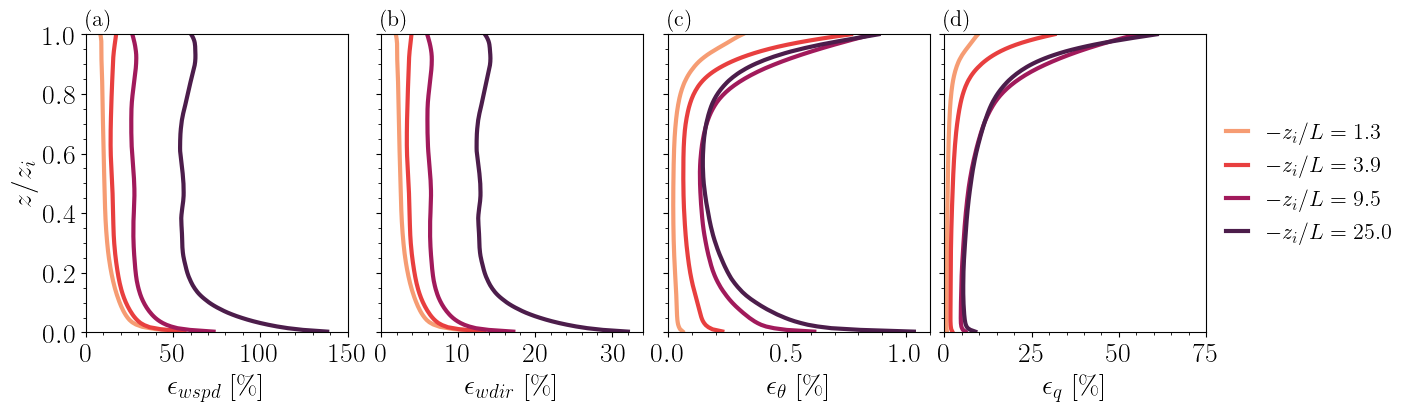

In [6]:
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(14, 4), constrained_layout=True)
for js, (e, s) in enumerate(zip(err, sall)):
    # wspd
    ax[0].plot(100*e.wspd, e.z/s.ht, c=colors[js], lw=3, label=s.ziL)
    # wdir
    ax[1].plot(100*e.wdir, e.z/s.ht, c=colors[js], lw=3)
    # theta
    ax[2].plot(100*e.theta, e.z/s.ht, c=colors[js], lw=3)
    # q
    ax[3].plot(100*e.q, e.z/s.ht, c=colors[js], lw=3, label=s.ziL)

# axis labels
ax[0].set_ylabel("$z/z_i$")
ax[0].set_xlabel(r"$\epsilon_{wspd}$ [\%]")
ax[1].set_xlabel(r"$\epsilon_{wdir}$ [\%]")
ax[2].set_xlabel(r"$\epsilon_{\theta}$ [\%]")
ax[3].set_xlabel(r"$\epsilon_{q}$ [\%]")

# axis limits
ax[0].set_ylim([0, 1])
ax[0].set_xlim([0, 150])
ax[1].set_xlim([0, 34])
ax[2].set_xlim([0, 1.1])
ax[3].set_xlim([0, 75])

# axis ticks and vertical lines
ax[0].yaxis.set_major_locator(MultipleLocator(0.2))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[0].xaxis.set_major_locator(MultipleLocator(50))
ax[0].xaxis.set_minor_locator(MultipleLocator(10))
ax[1].xaxis.set_major_locator(MultipleLocator(10))
ax[1].xaxis.set_minor_locator(MultipleLocator(2))
ax[2].xaxis.set_major_locator(MultipleLocator(0.5))
ax[2].xaxis.set_minor_locator(MultipleLocator(0.1))
ax[3].xaxis.set_major_locator(MultipleLocator(25))
ax[3].xaxis.set_minor_locator(MultipleLocator(5))

# legend
ax[3].legend(fontsize=16, bbox_to_anchor=(1, 0.5), frameon=False, loc="center left",
             handlelength=1)

# figure labels
[iax.set_title(f"({l})", loc="left", fontsize=16) for iax, l in zip(ax, list("abcd"))]
# save figure
if savefig:
    fsave = f"{figdir}errors_first_order.pdf"
    fig.savefig(fsave)

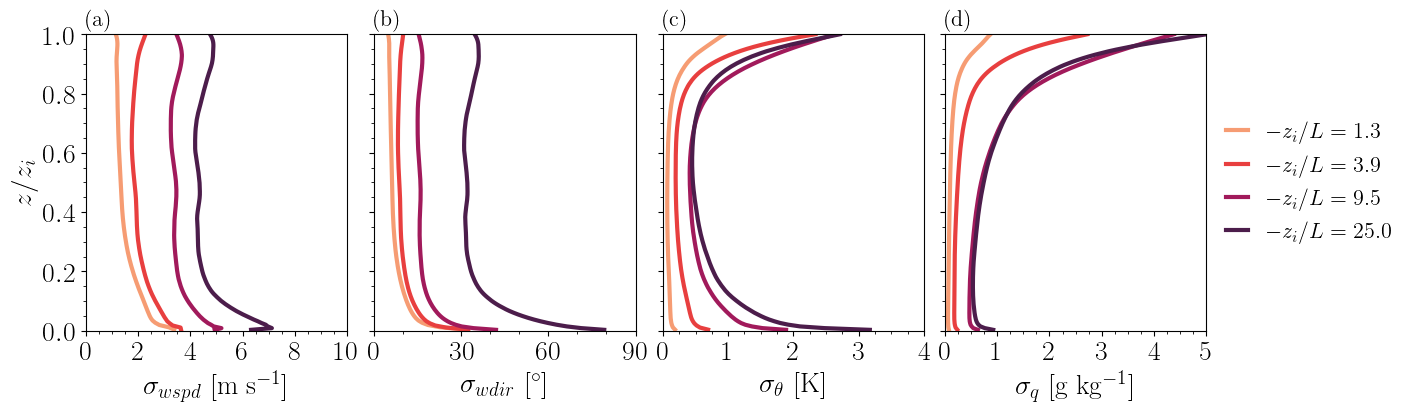

In [7]:
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(14, 4), constrained_layout=True)
for js, (e, s) in enumerate(zip(err, sall)):
    # wspd
    ax[0].plot(e.wspd*s.uh, e.z/s.ht, c=colors[js], lw=3, label=s.ziL)
    # wdir
    ax[1].plot(e.wdir*s.wdir, e.z/s.ht, c=colors[js], lw=3)
    # theta
    ax[2].plot(e.theta*s.theta_mean, e.z/s.ht, c=colors[js], lw=3)
    # q
    ax[3].plot(e.q*s.q_mean, e.z/s.ht, c=colors[js], lw=3, label=s.ziL)

# axis labels
ax[0].set_ylabel("$z/z_i$")
ax[0].set_xlabel(r"$\sigma_{wspd}$ [m s$^{-1}$]")
ax[1].set_xlabel(r"$\sigma_{wdir}$ [$^\circ$]")
ax[2].set_xlabel(r"$\sigma_{\theta}$ [K]")
ax[3].set_xlabel(r"$\sigma_{q}$ [g kg$^{-1}$]")

# axis limits
ax[0].set_ylim([0, 1])
ax[0].set_xlim([0, 10])
ax[1].set_xlim([0, 90])
ax[2].set_xlim([0, 4])
ax[3].set_xlim([0, 5])

# axis ticks and vertical lines
ax[0].yaxis.set_major_locator(MultipleLocator(0.2))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[0].xaxis.set_major_locator(MultipleLocator(2))
ax[0].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[1].xaxis.set_major_locator(MultipleLocator(30))
ax[1].xaxis.set_minor_locator(MultipleLocator(10))
ax[2].xaxis.set_major_locator(MultipleLocator(1))
ax[2].xaxis.set_minor_locator(MultipleLocator(0.25))
ax[3].xaxis.set_major_locator(MultipleLocator(1))
ax[3].xaxis.set_minor_locator(MultipleLocator(0.25))

# legend
ax[3].legend(fontsize=16, bbox_to_anchor=(1, 0.5), frameon=False, loc="center left",
             handlelength=1)

# figure labels
[iax.set_title(f"({l})", loc="left", fontsize=16) for iax, l in zip(ax, list("abcd"))]
# save figure
if savefig:
    fsave = f"{figdir}errors_first_order_dimensional.pdf"
    fig.savefig(fsave)

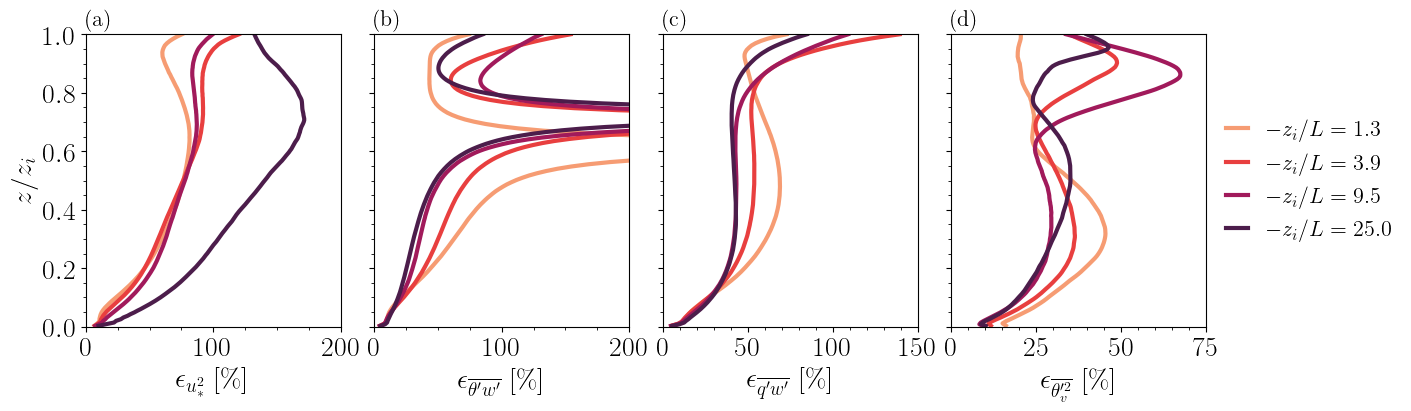

In [8]:
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(14, 4), constrained_layout=True)
for js, (e, s) in enumerate(zip(err, sall)):
    # ustar2
    ax[0].plot(100*e.ustar2, e.z/s.ht, c=colors[js], lw=3, label=s.ziL)
    # t'w'
    ax[1].plot(100*e.tw, e.z/s.ht, c=colors[js], lw=3)
    # q'w'
    ax[2].plot(100*e.qw, e.z/s.ht, c=colors[js], lw=3)
    # tv'tv'
    ax[3].plot(100*e.tvtv, e.z/s.ht, c=colors[js], lw=3, label=s.ziL)

# axis labels
ax[0].set_ylabel("$z/z_i$")
ax[0].set_xlabel(r"$\epsilon_{u_*^2}$ [\%]")
ax[1].set_xlabel(r"$\epsilon_{\overline{\theta'w'}}$ [\%]")
ax[2].set_xlabel(r"$\epsilon_{\overline{q'w'}}$ [\%]")
ax[3].set_xlabel(r"$\epsilon_{\overline{\theta_v'^2}}$ [\%]")

# axis limits
ax[0].set_ylim([0, 1])
ax[0].set_xlim([0, 200])
ax[1].set_xlim([0, 200])
ax[2].set_xlim([0, 150])
ax[3].set_xlim([0, 75])

# axis ticks and vertical lines
ax[0].yaxis.set_major_locator(MultipleLocator(0.2))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[0].xaxis.set_major_locator(MultipleLocator(100))
ax[0].xaxis.set_minor_locator(MultipleLocator(25))
ax[1].xaxis.set_major_locator(MultipleLocator(100))
ax[1].xaxis.set_minor_locator(MultipleLocator(25))
ax[2].xaxis.set_major_locator(MultipleLocator(50))
ax[2].xaxis.set_minor_locator(MultipleLocator(10))
ax[3].xaxis.set_major_locator(MultipleLocator(25))
ax[3].xaxis.set_minor_locator(MultipleLocator(5))

# legend
ax[3].legend(fontsize=16, bbox_to_anchor=(1, 0.5), frameon=False, loc="center left",
             handlelength=1)

# figure labels
[iax.set_title(f"({l})", loc="left", fontsize=16) for iax, l in zip(ax, list("abcd"))]
# save figure
if savefig:
    fsave = f"{figdir}errors_second_order.pdf"
    fig.savefig(fsave)

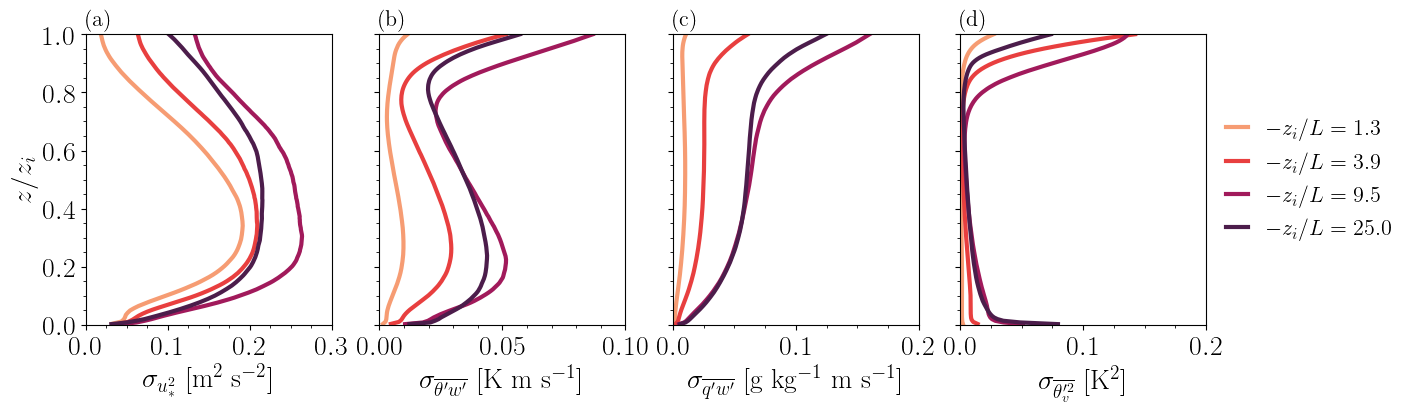

In [9]:
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(14, 4), constrained_layout=True)
for js, (e, s) in enumerate(zip(err, sall)):
    # ustar2
    ax[0].plot(e.ustar2*s.ustar2, e.z/s.ht, c=colors[js], lw=3, label=s.ziL)
    # t'w'
    ax[1].plot(e.tw*abs(s.tw_cov_tot), e.z/s.ht, c=colors[js], lw=3)
    # q'w'
    ax[2].plot(e.qw*abs(s.qw_cov_tot), e.z/s.ht, c=colors[js], lw=3)
    # tv'tv'
    ax[3].plot(e.tvtv*s.thetav_var, e.z/s.ht, c=colors[js], lw=3, label=s.ziL)

# axis labels
ax[0].set_ylabel("$z/z_i$")
ax[0].set_xlabel(r"$\sigma_{u_*^2}$ [m$^{2}$ s$^{-2}$]")
ax[1].set_xlabel(r"$\sigma_{\overline{\theta'w'}}$ [K m s$^{-1}$]")
ax[2].set_xlabel(r"$\sigma_{\overline{q'w'}}$ [g kg$^{-1}$ m s$^{-1}$]")
ax[3].set_xlabel(r"$\sigma_{\overline{\theta_v'^2}}$ [K$^2$]")

# axis limits
ax[0].set_ylim([0, 1])
ax[0].set_xlim([0, 0.3])
ax[1].set_xlim([0, 0.1])
ax[2].set_xlim([0, 0.2])
ax[3].set_xlim([0, 0.2])

# axis ticks and vertical lines
ax[0].yaxis.set_major_locator(MultipleLocator(0.2))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[0].xaxis.set_major_locator(MultipleLocator(0.1))
ax[0].xaxis.set_minor_locator(MultipleLocator(0.025))
ax[1].xaxis.set_major_locator(MultipleLocator(0.05))
ax[1].xaxis.set_minor_locator(MultipleLocator(0.01))
ax[2].xaxis.set_major_locator(MultipleLocator(0.1))
ax[2].xaxis.set_minor_locator(MultipleLocator(0.025))
ax[3].xaxis.set_major_locator(MultipleLocator(0.1))
ax[3].xaxis.set_minor_locator(MultipleLocator(0.025))

# legend
ax[3].legend(fontsize=16, bbox_to_anchor=(1, 0.5), frameon=False, loc="center left",
             handlelength=1)

# figure labels
[iax.set_title(f"({l})", loc="left", fontsize=16) for iax, l in zip(ax, list("abcd"))]
# save figure
if savefig:
    fsave = f"{figdir}errors_second_order_dimensional.pdf"
    fig.savefig(fsave)

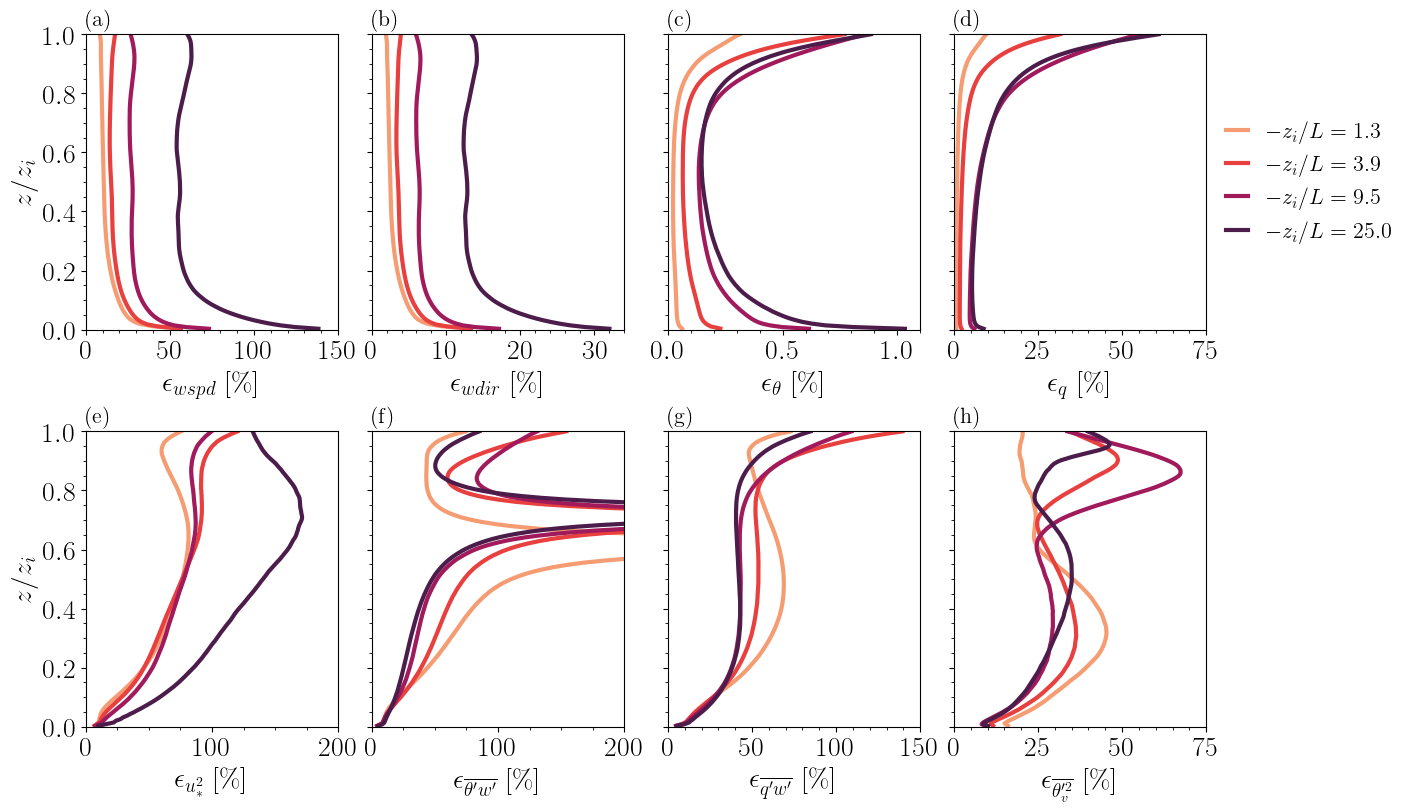

In [10]:
# combine error profiles into one
fig, ax = plt.subplots(2, 4, sharey=True, figsize=(14, 8), constrained_layout=True)
for js, (e, s) in enumerate(zip(err, sall)):
    # row 1
    # wspd
    ax[0,0].plot(100*e.wspd, e.z/s.ht, c=colors[js], lw=3, label=s.ziL)
    # wdir
    ax[0,1].plot(100*e.wdir, e.z/s.ht, c=colors[js], lw=3)
    # theta
    ax[0,2].plot(100*e.theta, e.z/s.ht, c=colors[js], lw=3)
    # q
    ax[0,3].plot(100*e.q, e.z/s.ht, c=colors[js], lw=3, label=s.ziL)
    # row 2
    # ustar2
    ax[1,0].plot(100*e.ustar2, e.z/s.ht, c=colors[js], lw=3, label=s.ziL)
    # t'w'
    ax[1,1].plot(100*e.tw, e.z/s.ht, c=colors[js], lw=3)
    # q'w'
    ax[1,2].plot(100*e.qw, e.z/s.ht, c=colors[js], lw=3)
    # tv'tv'
    ax[1,3].plot(100*e.tvtv, e.z/s.ht, c=colors[js], lw=3, label=s.ziL)

# axis labels
ax[0,0].set_ylabel("$z/z_i$")
ax[0,0].set_xlabel(r"$\epsilon_{wspd}$ [\%]")
ax[0,1].set_xlabel(r"$\epsilon_{wdir}$ [\%]")
ax[0,2].set_xlabel(r"$\epsilon_{\theta}$ [\%]")
ax[0,3].set_xlabel(r"$\epsilon_{q}$ [\%]")
ax[1,0].set_ylabel("$z/z_i$")
ax[1,0].set_xlabel(r"$\epsilon_{u_*^2}$ [\%]")
ax[1,1].set_xlabel(r"$\epsilon_{\overline{\theta'w'}}$ [\%]")
ax[1,2].set_xlabel(r"$\epsilon_{\overline{q'w'}}$ [\%]")
ax[1,3].set_xlabel(r"$\epsilon_{\overline{\theta_v'^2}}$ [\%]")

# axis limits
ax[0,0].set_ylim([0, 1])
ax[0,0].set_xlim([0, 150])
ax[0,1].set_xlim([0, 34])
ax[0,2].set_xlim([0, 1.1])
ax[0,3].set_xlim([0, 75])
ax[1,0].set_xlim([0, 200])
ax[1,1].set_xlim([0, 200])
ax[1,2].set_xlim([0, 150])
ax[1,3].set_xlim([0, 75])

# axis ticks and vertical lines
ax[0,0].yaxis.set_major_locator(MultipleLocator(0.2))
ax[0,0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[0,0].xaxis.set_major_locator(MultipleLocator(50))
ax[0,0].xaxis.set_minor_locator(MultipleLocator(10))
ax[0,1].xaxis.set_major_locator(MultipleLocator(10))
ax[0,1].xaxis.set_minor_locator(MultipleLocator(2))
ax[0,2].xaxis.set_major_locator(MultipleLocator(0.5))
ax[0,2].xaxis.set_minor_locator(MultipleLocator(0.1))
ax[0,3].xaxis.set_major_locator(MultipleLocator(25))
ax[0,3].xaxis.set_minor_locator(MultipleLocator(5))
ax[1,0].xaxis.set_major_locator(MultipleLocator(100))
ax[1,0].xaxis.set_minor_locator(MultipleLocator(25))
ax[1,1].xaxis.set_major_locator(MultipleLocator(100))
ax[1,1].xaxis.set_minor_locator(MultipleLocator(25))
ax[1,2].xaxis.set_major_locator(MultipleLocator(50))
ax[1,2].xaxis.set_minor_locator(MultipleLocator(10))
ax[1,3].xaxis.set_major_locator(MultipleLocator(25))
ax[1,3].xaxis.set_minor_locator(MultipleLocator(5))

# legend
ax[0,3].legend(fontsize=16, bbox_to_anchor=(1, 0.5), frameon=False, loc="center left",
             handlelength=1)

# figure labels
[iax.set_title(f"({l})", loc="left", fontsize=16) for iax, l in zip(ax.flatten(), list("abcdefgh"))]
# save figure
if savefig:
    fsave = f"{figdir}error_profiles.pdf"
    fig.savefig(fsave)

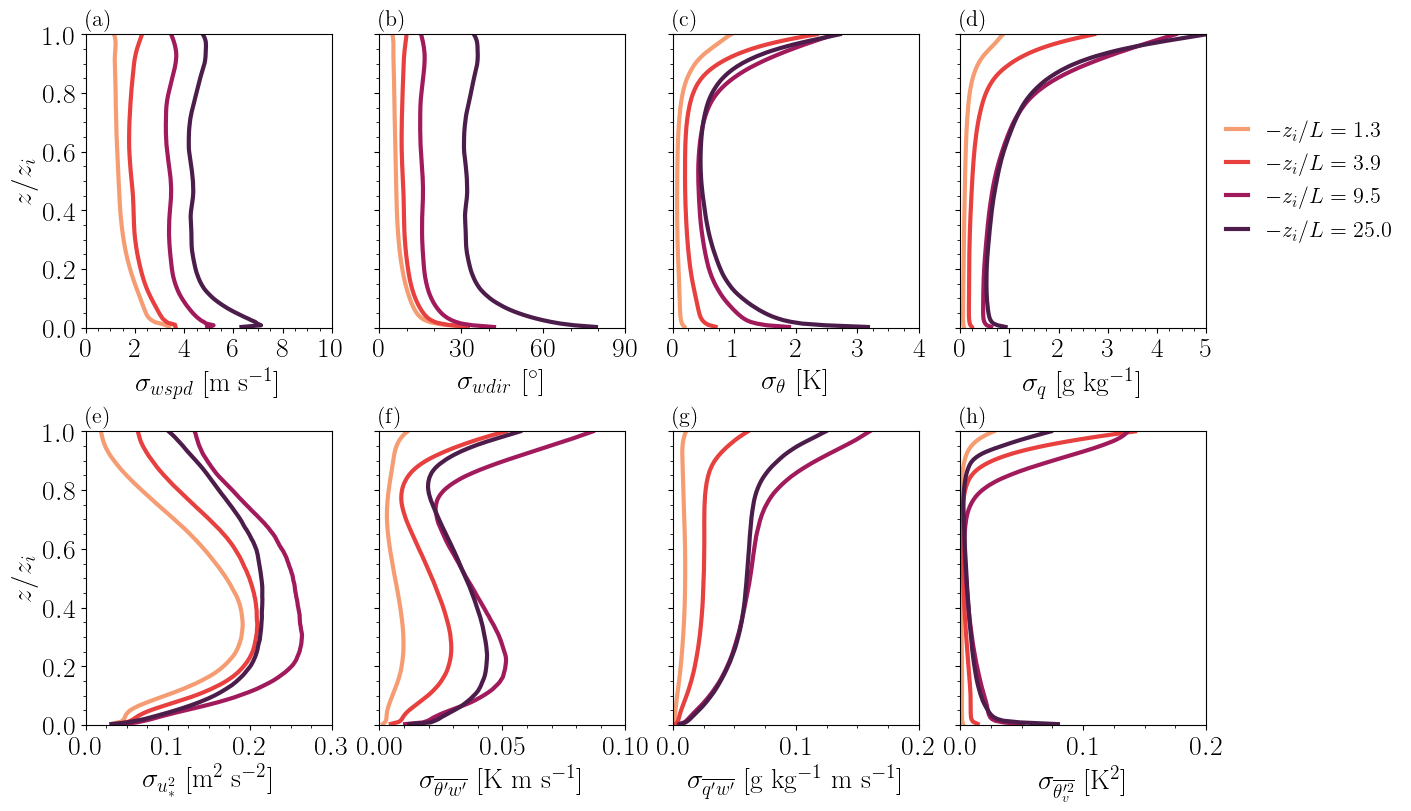

In [11]:
# combine error profiles into one
fig, ax = plt.subplots(2, 4, sharey=True, figsize=(14, 8), constrained_layout=True)
for js, (e, s) in enumerate(zip(err, sall)):
    # row 1
    # wspd
    ax[0,0].plot(e.wspd*s.uh, e.z/s.ht, c=colors[js], lw=3, label=s.ziL)
    # wdir
    ax[0,1].plot(e.wdir*s.wdir, e.z/s.ht, c=colors[js], lw=3)
    # theta
    ax[0,2].plot(e.theta*s.theta_mean, e.z/s.ht, c=colors[js], lw=3)
    # q
    ax[0,3].plot(e.q*s.q_mean, e.z/s.ht, c=colors[js], lw=3, label=s.ziL)
    # row 2
    # ustar2
    ax[1,0].plot(e.ustar2*s.ustar2, e.z/s.ht, c=colors[js], lw=3, label=s.ziL)
    # t'w'
    ax[1,1].plot(e.tw*abs(s.tw_cov_tot), e.z/s.ht, c=colors[js], lw=3)
    # q'w'
    ax[1,2].plot(e.qw*abs(s.qw_cov_tot), e.z/s.ht, c=colors[js], lw=3)
    # tv'tv'
    ax[1,3].plot(e.tvtv*s.thetav_var, e.z/s.ht, c=colors[js], lw=3, label=s.ziL)

# axis labels
ax[0,0].set_ylabel("$z/z_i$")
ax[0,0].set_xlabel(r"$\sigma_{wspd}$ [m s$^{-1}$]")
ax[0,1].set_xlabel(r"$\sigma_{wdir}$ [$^\circ$]")
ax[0,2].set_xlabel(r"$\sigma_{\theta}$ [K]")
ax[0,3].set_xlabel(r"$\sigma_{q}$ [g kg$^{-1}$]")
ax[1,0].set_ylabel("$z/z_i$")
ax[1,0].set_xlabel(r"$\sigma_{u_*^2}$ [m$^{2}$ s$^{-2}$]")
ax[1,1].set_xlabel(r"$\sigma_{\overline{\theta'w'}}$ [K m s$^{-1}$]")
ax[1,2].set_xlabel(r"$\sigma_{\overline{q'w'}}$ [g kg$^{-1}$ m s$^{-1}$]")
ax[1,3].set_xlabel(r"$\sigma_{\overline{\theta_v'^2}}$ [K$^2$]")

# axis limits
ax[0,0].set_ylim([0, 1])
ax[0,0].set_xlim([0, 10])
ax[0,1].set_xlim([0, 90])
ax[0,2].set_xlim([0, 4])
ax[0,3].set_xlim([0, 5])
ax[1,0].set_xlim([0, 0.3])
ax[1,1].set_xlim([0, 0.1])
ax[1,2].set_xlim([0, 0.2])
ax[1,3].set_xlim([0, 0.2])

# axis ticks and vertical lines
ax[0,0].yaxis.set_major_locator(MultipleLocator(0.2))
ax[0,0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[0,0].xaxis.set_major_locator(MultipleLocator(2))
ax[0,0].xaxis.set_minor_locator(MultipleLocator(0.5))
ax[0,1].xaxis.set_major_locator(MultipleLocator(30))
ax[0,1].xaxis.set_minor_locator(MultipleLocator(10))
ax[0,2].xaxis.set_major_locator(MultipleLocator(1))
ax[0,2].xaxis.set_minor_locator(MultipleLocator(0.25))
ax[0,3].xaxis.set_major_locator(MultipleLocator(1))
ax[0,3].xaxis.set_minor_locator(MultipleLocator(0.25))
ax[1,0].xaxis.set_major_locator(MultipleLocator(0.1))
ax[1,0].xaxis.set_minor_locator(MultipleLocator(0.025))
ax[1,1].xaxis.set_major_locator(MultipleLocator(0.05))
ax[1,1].xaxis.set_minor_locator(MultipleLocator(0.01))
ax[1,2].xaxis.set_major_locator(MultipleLocator(0.1))
ax[1,2].xaxis.set_minor_locator(MultipleLocator(0.025))
ax[1,3].xaxis.set_major_locator(MultipleLocator(0.1))
ax[1,3].xaxis.set_minor_locator(MultipleLocator(0.025))

# legend
ax[0,3].legend(fontsize=16, bbox_to_anchor=(1, 0.5), frameon=False, loc="center left",
             handlelength=1)

# figure labels
[iax.set_title(f"({l})", loc="left", fontsize=16) for iax, l in zip(ax.flatten(), list("abcdefgh"))]
# save figure
if savefig:
    fsave = f"{figdir}error_profiles_dimensional.pdf"
    fig.savefig(fsave)

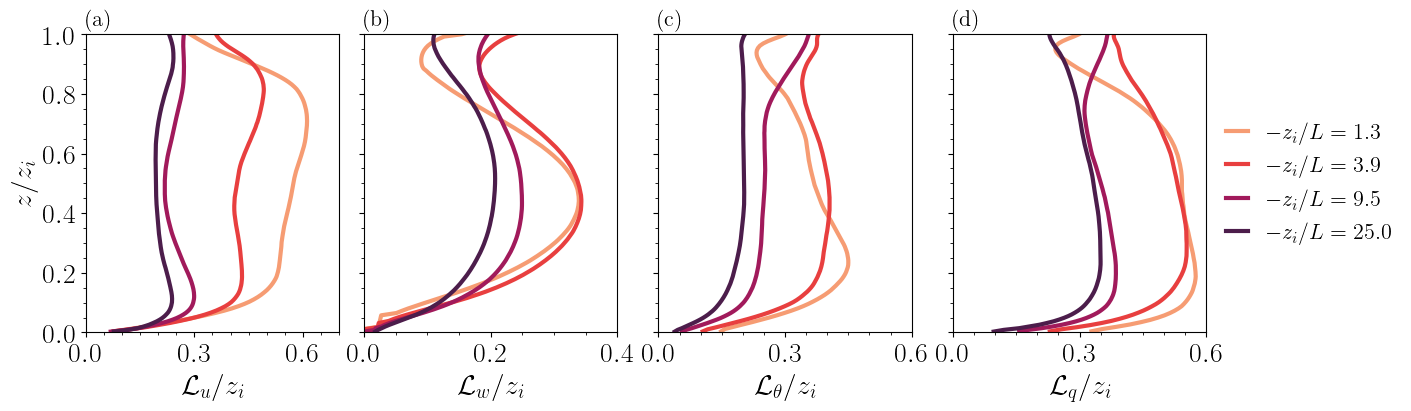

In [12]:
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(14, 4), constrained_layout=True)
for js, (l, s) in enumerate(zip(Lall, sall)):
    # u
    ax[0].plot(l.u_rot/s.ht, l.z/s.ht, c=colors[js], lw=3, label=s.ziL)
    # w
    ax[1].plot(l.w/s.ht, l.z/s.ht, c=colors[js], lw=3)
    # theta
    ax[2].plot(l.theta/s.ht, l.z/s.ht, c=colors[js], lw=3)
    # q
    ax[3].plot(l.q/s.ht, l.z/s.ht, c=colors[js], lw=3, label=s.ziL)

ax[0].set_ylim([0, 1])
ax[0].set_ylabel("$z/z_i$")
ax[0].yaxis.set_major_locator(MultipleLocator(0.2))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[0].set_xlim([0, 0.7])
ax[0].xaxis.set_major_locator(MultipleLocator(0.3))
ax[0].xaxis.set_minor_locator(MultipleLocator(0.05))
ax[0].set_xlabel(r"$\mathcal{L}_u/z_i$")
ax[1].set_xlim([0, 0.4])
ax[1].xaxis.set_major_locator(MultipleLocator(0.2))
ax[1].xaxis.set_minor_locator(MultipleLocator(0.05))
ax[1].set_xlabel(r"$\mathcal{L}_w/z_i$")
ax[2].set_xlim([0, 0.6])
ax[2].xaxis.set_major_locator(MultipleLocator(0.3))
ax[2].xaxis.set_minor_locator(MultipleLocator(0.05))
ax[2].set_xlabel(r"$\mathcal{L}_\theta/z_i$")
ax[3].set_xlim([0, 0.6])
ax[3].xaxis.set_major_locator(MultipleLocator(0.3))
ax[3].xaxis.set_minor_locator(MultipleLocator(0.05))
ax[3].set_xlabel(r"$\mathcal{L}_q/z_i$")

# legend
ax[3].legend(fontsize=16, bbox_to_anchor=(1, 0.5), frameon=False, loc="center left",
             handlelength=1)

# figure labels
[iax.set_title(f"({l})", loc="left", fontsize=16) for iax, l in zip(ax, list("abcd"))]
# save figure
if savefig:
    fsave = f"{figdir}lengthscales.pdf"
    fig.savefig(fsave)

# Recalc errors with array of times

In [13]:
def err_array(dnc, Tnew):
    s = load_stats(dnc+"mean_stats_xyt_5-6h.nc")
    L = xr.load_dataset(dnc+"lengthscale.nc")
    C = xr.load_dataset(dnc+"fit_C.nc")
    p = xr.load_dataset(dnc+"fit_p.nc")
    # add labels using -zi/L
    ziL = -1 * (s.ht/s.L).values
    s.attrs["ziL"] = f"$-z_i/L = {ziL:.1f}$"

    return recalc_err_array(Tnew, s, C, p, L), s

In [14]:
dsim = "/home/bgreene/simulations/CBL/"
sims = ["u15_tw03_qw01_dq-06", "u09_tw24_qw10_dq-06"]
Tnew = np.arange(0.1, 30.1, 0.1)
err_new = []
s_use = []

for sim in sims:
    e, s = err_array(f"{dsim}{sim}/", Tnew)
    err_new.append(e)
    s_use.append(s)

Reading file: /home/bgreene/simulations/CBL/u15_tw03_qw01_dq-06/mean_stats_xyt_5-6h.nc
Computing errors for: u
Computing errors for: v
Computing errors for: theta
Computing errors for: q
Computing errors for: thetav
Reading file: /home/bgreene/simulations/CBL/u09_tw24_qw10_dq-06/mean_stats_xyt_5-6h.nc
Computing errors for: u
Computing errors for: v
Computing errors for: theta
Computing errors for: q
Computing errors for: thetav


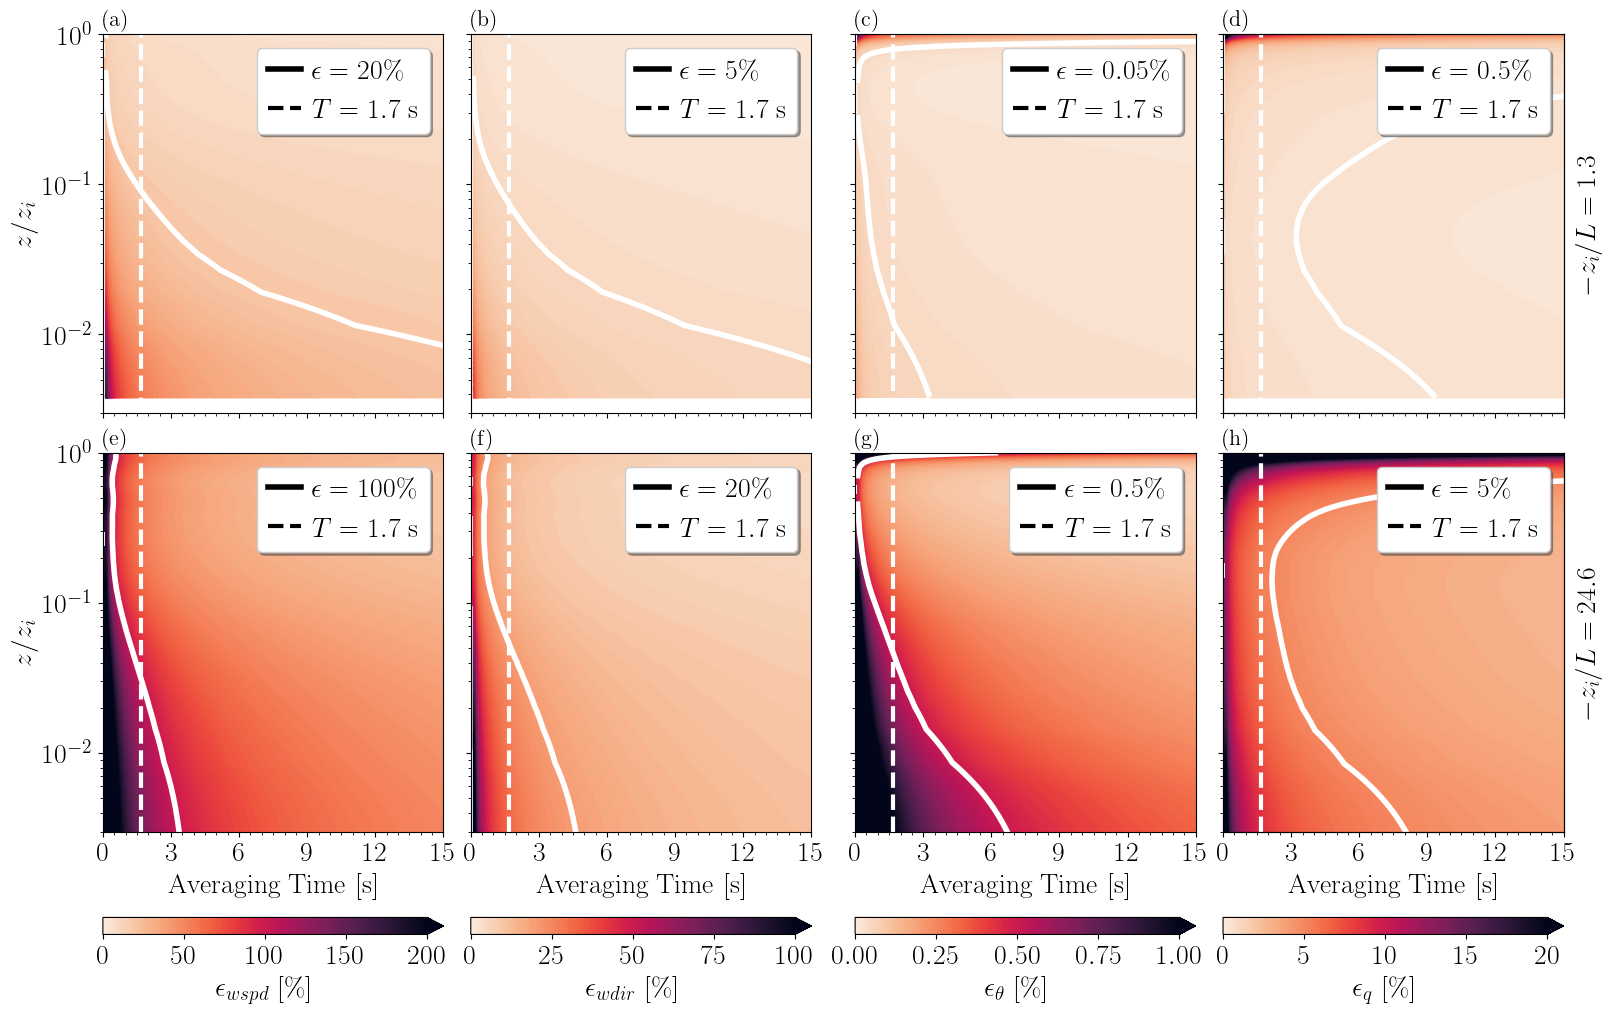

In [15]:
# PLOT WITH LINEAR COLORBAR
fig, ax = plt.subplots(nrows=2, ncols=4, sharey=True, sharex=True,
                       figsize=(16, 10), constrained_layout=True)

# row 1: -zi/L=1
# row 2: -zi/L=25
cmap_err = sb.color_palette("rocket_r", as_cmap=True)
for js, (s, e) in enumerate(zip(s_use, err_new)):
    # col 0: wspd
    cfax0 = ax[js,0].contourf(Tnew, e.z/s.ht, 100*e.wspd,
                              levels=np.linspace(0, 200, 101), extend="max",
                              cmap=cmap_err, zorder=-10)
    # col 1: wdir
    cfax1 = ax[js,1].contourf(Tnew, e.z/s.ht, 100*e.wdir,
                              levels=np.linspace(0, 100, 101), extend="max",
                              cmap=cmap_err, zorder=-10)
    # col 2: theta
    cfax2 = ax[js,2].contourf(Tnew, e.z/s.ht, 100*e.theta,
                              levels=np.linspace(0, 1, 101), extend="max",
                              cmap=cmap_err, zorder=-10)
    # col 3: q
    cfax3 = ax[js,3].contourf(Tnew, e.z/s.ht, 100*e.q,
                              levels=np.linspace(0, 20, 101), extend="max",
                              cmap=cmap_err, zorder=-10)
    if js == 0:
        lvlc = [[20], [5], [0.05], [0.5]]
    else:
        lvlc = [[100], [20], [0.5], [5]]
    # contours for set error level
    cax0 = ax[js,0].contour(Tnew, e.z/s.ht, 100.*e.wspd, colors="w", levels=lvlc[0], linewidths=4.)
    cax1 = ax[js,1].contour(Tnew, e.z/s.ht, 100.*e.wdir, colors="w", levels=lvlc[1], linewidths=4.)
    cax2 = ax[js,2].contour(Tnew, e.z/s.ht, 100.*e.theta, colors="w", levels=lvlc[2], linewidths=4.)
    cax3 = ax[js,3].contour(Tnew, e.z/s.h, 100.*e.q, colors="w", levels=lvlc[3], linewidths=4.)
    # set edgecolor
    for cax in [cfax0, cfax1, cfax2, cfax3]:
        for c in cax.collections:
            c.set_edgecolor("face")

# rasterize levels
for iax in ax.flatten():
    iax.set_rasterization_zorder(-1)

# colorbars
cb0 = fig.colorbar(cfax0, ax=ax[:,0], location="bottom",
                   ticks=np.linspace(0, 200, 5), pad=0.02,
                   label=r"$\epsilon_{wspd}$ [\%]")
cb1 = fig.colorbar(cfax1, ax=ax[:,1], location="bottom",
                   ticks=np.linspace(0, 100, 5), pad=0.02,
                   label=r"$\epsilon_{wdir}$ [\%]")
cb2 = fig.colorbar(cfax2, ax=ax[:,2], location="bottom",
                   ticks=np.linspace(0, 1, 5), pad=0.02,
                   label=r"$\epsilon_{\theta}$ [\%]")
cb3 = fig.colorbar(cfax3, ax=ax[:,3], location="bottom",
                   ticks=np.linspace(0, 20, 5), pad=0.02,
                   label=r"$\epsilon_{q}$ [\%]")

# axis scales
ax[0,0].set_yscale("log")
# axis limits
ax[0,0].set_ylim([3e-3, 1e0])
ax[0,0].set_xlim([0, 15])
# axis labels
[iax.set_xlabel("Averaging Time [s]") for iax in ax[-1,:]]
[iax.set_ylabel("$z/z_i$") for iax in ax[:,0]]
# axis ticks
ax[0,0].xaxis.set_major_locator(MultipleLocator(3))
ax[0,0].xaxis.set_minor_locator(MultipleLocator(0.5))
# subplot titles
[iax.set_title(f"({lab})", loc="left", fontsize=16) for iax, lab in zip(ax.flatten(), list("abcdefgh"))]
# add zi/L labels on right hand side
ax0b = ax[0,-1].twinx()
ax0b.set_ylabel(s_use[0].ziL)
ax0b.set_yticks([])
ax1b = ax[1,-1].twinx()
ax1b.set_ylabel(s_use[1].ziL)
ax1b.set_yticks([])
# vertical lines for averaging time of typical CopterSonde postprocessing
tav = 5/3.
# legends, vertical lines for each subpanel
# define contour levels from each panel
reflines = [20, 5, 0.05, 0.5, 100, 20, 0.5, 5]
for iax, ref in zip(ax.flatten(), reflines):
    iax.plot([], [], ls="-", c="k", lw=4, label=rf"$\epsilon={ref}\%$")
    iax.axvline(tav, c="w", ls="--", lw=3)
    iax.plot([], [], ls="--", c="k", lw=3, label=f"$T={tav:.1f}$ s")
    # iax.legend(loc="lower right", fontsize=18, frameon=False, handletextpad=0.4,
    #            bbox_to_anchor=(1.05, 0.94), ncols=2, handlelength=1, columnspacing=0.6)
    iax.legend(loc="upper right", handletextpad=0.4, handlelength=1.2, shadow=True)
# save figure
if savefig:
    fsave = f"{figdir}error_contours.pdf"
    fig.savefig(fsave)

# Optimal ascent rates

## Weakly Convective

In [63]:
err_range = [0.50, 0.25, 0.10, 0.05, 0.02, 0.01] # x100 = percent
delta_z = 5. # m
ne = len(err_range)
e = err_new[0]
s = s_use[0]
# determine averaging time to be at/below err for each z
# create empty dataarrays in err for storing
e["t_wspd"] = xr.DataArray(np.zeros((s.nzabl, ne), np.float64),
                             coords=dict(z=e.z, err=err_range))
e["t_wdir"] = xr.DataArray(np.zeros((s.nzabl, ne), np.float64),
                             coords=dict(z=e.z, err=err_range))
e["t_theta"] = xr.DataArray(np.zeros((s.nzabl, ne), np.float64),
                             coords=dict(z=e.z, err=err_range))
e["t_q"] = xr.DataArray(np.zeros((s.nzabl, ne), np.float64),
                             coords=dict(z=e.z, err=err_range))

# loop over error level
for je, lvl in enumerate(err_range):
    # loop over height
    for jz in range(s.nzabl):
        # wspd
        iwspd = np.where(e.wspd.isel(z=jz) <= lvl)[0]
        # check for empty array
        if np.size(iwspd) > 0:
            e["t_wspd"][jz,je] = Tnew[iwspd[0]]
        else:
            e["t_wspd"][jz,je] = np.nan
        # wdir
        iwdir = np.where(e.wdir.isel(z=jz) <= lvl)[0]
        # check for empty array
        if np.size(iwdir) > 0:
            e["t_wdir"][jz,je] = Tnew[iwdir[0]]
        else:
            e["t_wdir"][jz,je] = np.nan
        # theta
        itheta = np.where(e.theta.isel(z=jz) <= lvl)[0]
        # check for empty array
        if np.size(itheta) > 0:
            e["t_theta"][jz,je] = Tnew[itheta[0]]
        else:
            e["t_theta"][jz,je] = np.nan
        # q
        iq = np.where(e.q.isel(z=jz) <= lvl)[0]
        # check for empty array
        if np.size(iq) > 0:
            e["t_q"][jz,je] = Tnew[iq[0]]
        else:
            e["t_q"][jz,je] = np.nan

# now can calculate ascent rate based on fixed delta_z
e["vz_wspd"] = delta_z / e.t_wspd
e["vz_wdir"] = delta_z / e.t_wdir
e["vz_theta"] = delta_z / e.t_theta
e["vz_q"] = delta_z / e.t_q
e.attrs["vz_min"] = s.h.values / (15 * 60)

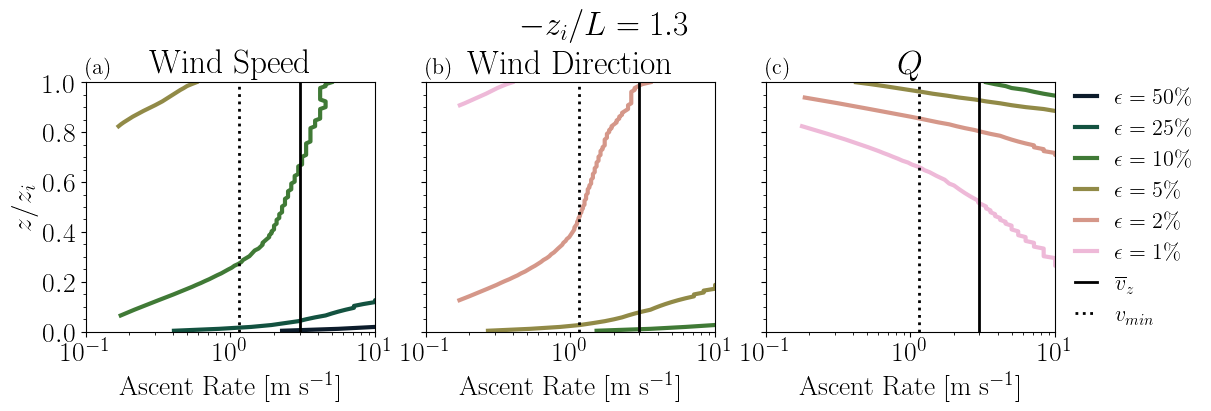

In [64]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4), constrained_layout=True)

ecmap = sb.cubehelix_palette(n_colors=len(err_range), start=0, rot=-1, gamma=1, hue=1, 
                                 light=0.8, dark=0.1, reverse=True)

for je, lvl in enumerate(err_range):
    label = rf"$\epsilon={int(100*lvl)}\%$"
    # wspd
    ax[0].semilogx(e.vz_wspd.isel(err=je), e.z/s.ht, lw=3, c=ecmap[je], label=lvl)
    # wdir
    ax[1].semilogx(e.vz_wdir.isel(err=je), e.z/s.ht, lw=3, c=ecmap[je], label=lvl)
    # q
    ax[2].semilogx(e.vz_q.isel(err=je), e.z/s.ht, lw=3, c=ecmap[je], label=label)

# ax[0].set_ylim([3e-3, 1e0])
ax[0].set_ylim([0, 1])
ax[0].yaxis.set_major_locator(MultipleLocator(0.2))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[0].set_xlim([1e-1, 1e1])
[iax.set_xlabel("Ascent Rate [m s$^{-1}$]")]
ax[0].set_ylabel("$z/z_i$")
ax[0].set_title("Wind Speed")
ax[1].set_title("Wind Direction")
ax[2].set_title("$Q$")

[iax.set_title(f"({l})", loc="left", fontsize=16) for iax, l in zip(ax, list("abc"))]
[iax.set_xlabel("Ascent Rate [m s$^{-1}$]") for iax in ax]
[iax.axvline(3, c="k", lw=2, label=r"$\overline{v}_z$") for iax in ax]
[iax.axvline(e.vz_min, c="k", ls=":", lw=2, label="$v_{min}$") for iax in ax]
# legend
ax[2].legend(fontsize=16, bbox_to_anchor=(1, 0.5), frameon=False, loc="center left",
             handlelength=1)
fig.suptitle(s.ziL)
# save figure
if savefig:
    fsave = f"{figdir}optimal_ascent_rates_ziL{-s.ziL_raw:.1f}.pdf"
    fig.savefig(fsave)

## Hightly Convective

In [65]:
err_range = [0.50, 0.25, 0.10, 0.05, 0.02, 0.01] # x100 = percent
delta_z = 5. # m
ne = len(err_range)
e = err_new[1]
s = s_use[1]
# determine averaging time to be at/below err for each z
# create empty dataarrays in err for storing
e["t_wspd"] = xr.DataArray(np.zeros((s.nzabl, ne), np.float64),
                             coords=dict(z=e.z, err=err_range))
e["t_wdir"] = xr.DataArray(np.zeros((s.nzabl, ne), np.float64),
                             coords=dict(z=e.z, err=err_range))
e["t_theta"] = xr.DataArray(np.zeros((s.nzabl, ne), np.float64),
                             coords=dict(z=e.z, err=err_range))
e["t_q"] = xr.DataArray(np.zeros((s.nzabl, ne), np.float64),
                             coords=dict(z=e.z, err=err_range))

# loop over error level
for je, lvl in enumerate(err_range):
    # loop over height
    for jz in range(s.nzabl):
        # wspd
        iwspd = np.where(e.wspd.isel(z=jz) <= lvl)[0]
        # check for empty array
        if np.size(iwspd) > 0:
            e["t_wspd"][jz,je] = Tnew[iwspd[0]]
        else:
            e["t_wspd"][jz,je] = np.nan
        # wdir
        iwdir = np.where(e.wdir.isel(z=jz) <= lvl)[0]
        # check for empty array
        if np.size(iwdir) > 0:
            e["t_wdir"][jz,je] = Tnew[iwdir[0]]
        else:
            e["t_wdir"][jz,je] = np.nan
        # theta
        itheta = np.where(e.theta.isel(z=jz) <= lvl)[0]
        # check for empty array
        if np.size(itheta) > 0:
            e["t_theta"][jz,je] = Tnew[itheta[0]]
        else:
            e["t_theta"][jz,je] = np.nan
        # q
        iq = np.where(e.q.isel(z=jz) <= lvl)[0]
        # check for empty array
        if np.size(iq) > 0:
            e["t_q"][jz,je] = Tnew[iq[0]]
        else:
            e["t_q"][jz,je] = np.nan

# now can calculate ascent rate based on fixed delta_z
e["vz_wspd"] = delta_z / e.t_wspd
e["vz_wdir"] = delta_z / e.t_wdir
e["vz_theta"] = delta_z / e.t_theta
e["vz_q"] = delta_z / e.t_q
e.attrs["vz_min"] = s.h.values / (15 * 60)

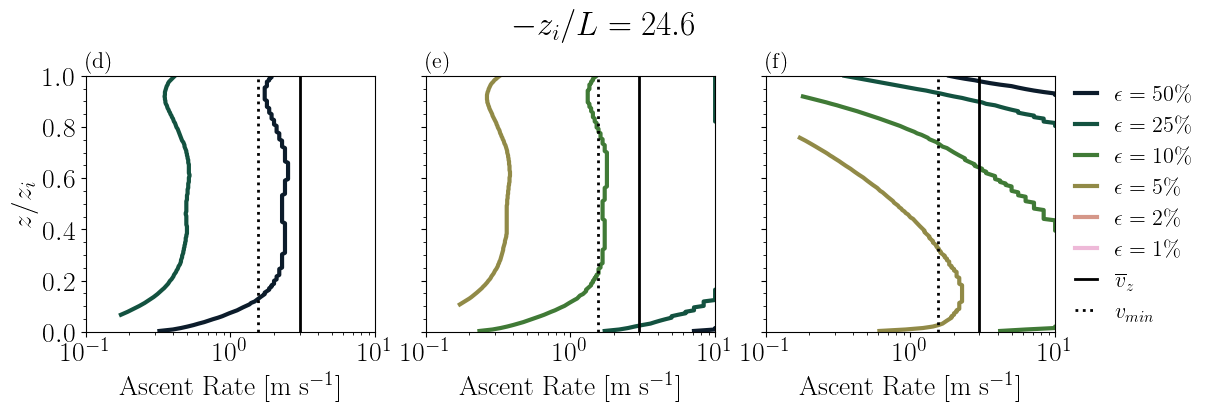

In [66]:
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(12, 4), constrained_layout=True)

ecmap = sb.cubehelix_palette(n_colors=len(err_range), start=0, rot=-1, gamma=1, hue=1, 
                                 light=0.8, dark=0.1, reverse=True)

for je, lvl in enumerate(err_range):
    label = rf"$\epsilon={int(100*lvl)}\%$"
    # wspd
    ax[0].semilogx(e.vz_wspd.isel(err=je), e.z/s.ht, lw=3, c=ecmap[je], label=lvl)
    # wdir
    ax[1].semilogx(e.vz_wdir.isel(err=je), e.z/s.ht, lw=3, c=ecmap[je], label=lvl)
    # q
    ax[2].semilogx(e.vz_q.isel(err=je), e.z/s.ht, lw=3, c=ecmap[je], label=label)

# ax[0].set_ylim([3e-3, 1e0])
ax[0].set_ylim([0, 1])
ax[0].yaxis.set_major_locator(MultipleLocator(0.2))
ax[0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax[0].set_xlim([1e-1, 1e1])
[iax.set_xlabel("Ascent Rate [m s$^{-1}$]")]
ax[0].set_ylabel("$z/z_i$")
# ax[0].set_title("Wind Speed")
# ax[1].set_title("Wind Direction")
# ax[2].set_title("$Q$")

[iax.set_title(f"({l})", loc="left", fontsize=16) for iax, l in zip(ax, list("def"))]
[iax.set_xlabel("Ascent Rate [m s$^{-1}$]") for iax in ax]
[iax.axvline(3, c="k", lw=2, label=r"$\overline{v}_z$") for iax in ax]
[iax.axvline(e.vz_min, c="k", ls=":", lw=2, label="$v_{min}$") for iax in ax]
# legend
ax[2].legend(fontsize=16, bbox_to_anchor=(1, 0.5), frameon=False, loc="center left",
             handlelength=1)
fig.suptitle(s.ziL)
# save figure
if savefig:
    fsave = f"{figdir}optimal_ascent_rates_ziL{-s.ziL_raw:.1f}.pdf"
    fig.savefig(fsave)

# Save files with data that went into generating figures

In [80]:
# define directory to save these files
dsave_ref = "/home/bgreene/CBL-DOE/output/RFM_figure_files/"

## Mean Stats Files

In [81]:
# define variables to keep
vkeep = ["u_mean", "v_mean", "w_mean", "theta_mean", "q_mean",
         "thetav_mean", "tvw_cov_tot", "thetav_var",
         "txz_mean", "tyz_mean", "tw_sgs_mean", "qw_sgs_mean",
         "uw_cov_res", "vw_cov_res", "tw_cov_res", "qw_cov_res",
         "u_var", "v_var", "w_var", "theta_var", "q_var", 
         "u_var_rot", "v_var_rot", "uw_cov_tot", "vw_cov_tot",
         "tw_cov_tot", "qw_cov_tot"]
# define attributes to keep
akeep = ["nx", "ny", "nz", "Lx", "Ly", "Lz", "wt_s", "wq_s", 
         "Ug", "Vg", "coriol"]

# loop over files
for s in sall:
    snew = s[vkeep]
    snew.attrs = {key: s.attrs[key] for key in akeep if key in s.attrs}
    # save file
    fsave = f"mean_stats_ziL_{-1*s.ziL_raw:.1f}.nc"
    snew.to_netcdf(dsave_ref+fsave)

## Random Errors

In [86]:
# define variables to keep
vkeep = ["wspd", "wdir", "theta", "q", "ustar2", "tw", "qw", "tvtv"]
# define attributes to keep
akeep = ["nx", "ny", "nz", "Lx", "Ly", "Lz", "wt_s", "wq_s", 
         "Ug", "Vg", "coriol"]
# loop over error files
for s, e in zip(sall, err):
    enew = e[vkeep]
    enew.attrs = {key: e.attrs[key] for key in akeep if key in e.attrs}
    # save file
    fsave = f"random_errors_ziL_{-1*s.ziL_raw:.1f}.nc"
    enew.to_netcdf(dsave_ref+fsave)

## Errors versus time and height, Optimal Ascent Rate

In [87]:
# define variables to keep
vkeep = [v for v in err_new[0].data_vars if v not in ['u', 'v', 'thetav']]
# define attributes to keep
akeep = ["nx", "ny", "nz", "Lx", "Ly", "Lz", "wt_s", "wq_s", 
         "Ug", "Vg", "coriol", "vz_min"]
# loop over new error files
for s, e in zip(s_use, err_new):
    enew = e[vkeep]
    enew.attrs = {key: e.attrs[key] for key in akeep if key in e.attrs}
    # save file
    fsave = f"errors_vs_time_ascent_rate_ziL_{-1*s.ziL_raw:.1f}.nc"
    enew.to_netcdf(dsave_ref+fsave)